# Demo phương pháp Community Detection với Spark
* Community detection là một bài toán phổ biến trong các bài toán network, có thể dùng để phát hiện ra các hành vi của một nhóm người dùng hoặc các hiện tượng mới nổi.
* Yếu tố của nó là các thành viên trong một nhóm sẽ có nhiều mối quan hệ với các thành viên cùng nhóm đó hơn là các thành viên bên ngoài nhóm đó.
* Lợi ích của community detection là giúp suy ra được hành vi - sở thích của các nhóm, tìm kiếm các mối quan hệ,...


## Triangle Count
* Là một phương pháp dùng để đếm số tam giác bên trong đồ thị.
* Một tam giác được tạo ra bởi 3 node.
* Giá trị lớn nhất là 1, đồng thời cũng cho biết mọi cặp node trong đồ thị đều được kết nối với nhau.

<center>

![](./images/01.png)

_Hình lấy từ trang 115 quyển Graph Algorithm_

</center>


### Công thức
$$CC(u) = \dfrac{2 \times \text{số tam giác được tạo mà cần node } u}{k \times (k - 1)}$$

trong đó:
  * $k$ là là degree của $u$.

In [1]:
from graphframes.lib import AggregateMessages as AM
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark import SparkContext
from graphframes import *
from operator import itemgetter
import matplotlib.pyplot as plt
import networkx as nx
import findspark
import pandas as pd

findspark.init()

In [2]:
spark = SparkSession.builder.appName("PageRank").getOrCreate()
sc = spark.sparkContext

22/01/14 21:46:59 WARN Utils: Your hostname, Rose resolves to a loopback address: 127.0.1.1; using 192.168.1.14 instead (on interface enp3s0)
22/01/14 21:46:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/14 21:47:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
def plotGraph(edges):
    plt.figure(figsize=(12, 8))
    G_symmetric = nx.DiGraph()
    for row in edges.collect():
        G_symmetric.add_edge(row['src'], row['dst'])
    nx.degree_centrality(G_symmetric)
    pos = nx.planar_layout(G_symmetric)
    betCent = nx.betweenness_centrality(G_symmetric, normalized=True, endpoints=True)
    node_color = [G_symmetric.degree(v) for v in G_symmetric]
    node_size =  [v * 10000 for v in betCent.values()]
    plt.figure(figsize=(10,10))
    nx.draw_networkx(G_symmetric, pos=pos, with_labels=True,
                    node_color=node_color,
                    node_size=node_size)

In [4]:
def create_software_graph():
    nodes = spark.read.csv("data/sw-nodes.csv", header=True)
    relationships = spark.read.csv("data/sw-relationships.csv", header=True)
    return GraphFrame(nodes, relationships)

In [5]:
g = create_software_graph()

In [6]:
result = g.triangleCount()

result.sort("count", ascending=False).filter('count > 0').show()

+-----+---------------+
|count|             id|
+-----+---------------+
|    1|      ipykernel|
|    1|python-dateutil|
|    1|    jpy-console|
|    1|            six|
|    1|     matplotlib|
|    1|        jupyter|
+-----+---------------+



<Figure size 864x576 with 0 Axes>

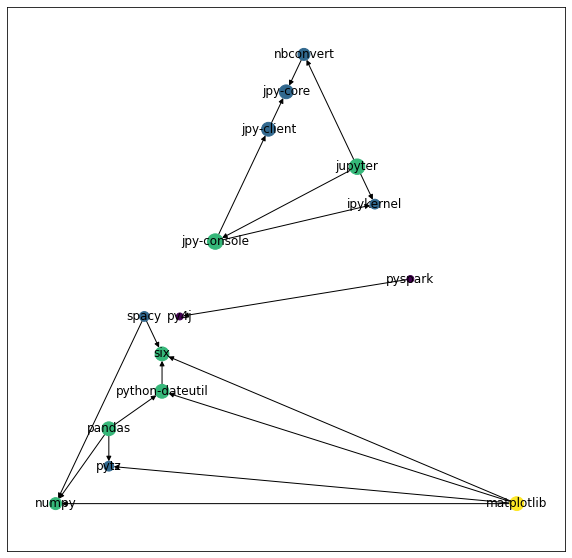

In [7]:
plotGraph(g.edges)

## Các thuật toán khác được Spark hỗ trợ
* Strongly Connected Components.

In [8]:
result = g.stronglyConnectedComponents(maxIter=10)
(result.sort("component")
.groupby("component")
.agg(F.collect_list("id").alias("libraries"))
.show(truncate=False))

+-------------+-----------------+
|component    |libraries        |
+-------------+-----------------+
|180388626432 |[jpy-core]       |
|223338299392 |[spacy]          |
|498216206336 |[numpy]          |
|523986010112 |[six]            |
|549755813888 |[pandas]         |
|558345748480 |[nbconvert]      |
|661424963584 |[ipykernel]      |
|721554505728 |[jupyter]        |
|764504178688 |[jpy-client]     |
|833223655424 |[pytz]           |
|910533066752 |[python-dateutil]|
|936302870528 |[pyspark]        |
|944892805120 |[matplotlib]     |
|1099511627776|[jpy-console]    |
|1279900254208|[py4j]           |
+-------------+-----------------+



* Label Propagation

In [10]:
result = g.labelPropagation(maxIter=10)
(result
.sort("label")
.groupby("label")
.agg(F.collect_list("id"))
.show(truncate=False))

+-------------+----------------------------------+
|label        |collect_list(id)                  |
+-------------+----------------------------------+
|549755813888 |[matplotlib, spacy, six, pandas]  |
|764504178688 |[nbconvert, ipykernel, jpy-client]|
|833223655424 |[python-dateutil, numpy, pytz]    |
|936302870528 |[pyspark]                         |
|1099511627776|[jpy-core, jpy-console, jupyter]  |
|1279900254208|[py4j]                            |
+-------------+----------------------------------+



* Connected Components

In [12]:
sc.setCheckpointDir(dirName="./graphframes_cps")
result = g.connectedComponents()
(result.sort("component")
.groupby("component")
.agg(F.collect_list("id").alias("libraries"))
.show(truncate=False))

22/01/14 21:51:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/01/14 21:51:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
22/01/14 21:51:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
22/01/14 21:51:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
22/01/14 21:51:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
22/01/14 21:51:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
22/01/14 21:51:36 WARN MemoryManager: Total allocation exceeds 95.

+------------+------------------------------------------------------------------+
|component   |libraries                                                         |
+------------+------------------------------------------------------------------+
|180388626432|[jpy-core, nbconvert, ipykernel, jupyter, jpy-client, jpy-console]|
|223338299392|[spacy, numpy, six, pandas, pytz, python-dateutil, matplotlib]    |
|936302870528|[pyspark, py4j]                                                   |
+------------+------------------------------------------------------------------+

